# Meridional Heat Transport

Plots the meridional heat transport for a set of four CESM2-MOM6 simulations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, yaml, os
from datetime import datetime
import getpass
import xarray as xr
warnings.filterwarnings("ignore")
from mom6_tools.DiagsCase import DiagsCase
import os
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import cmocean

from mom6_tools  import m6toolbox

def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path

def heatTrans(advective, diffusive=None, hbd=None, vmask=None):
  """Converts vertically integrated temperature advection into heat transport"""
  HT = advective[:]
  if diffusive is not None:
    HT = HT + diffusive[:]
  if hbd is not None:
    HT = HT + hbd[:]
  if len(HT.shape) == 3:
    HT = HT.mean(axis=0)
  if advective.units == "Celsius meter3 second-1":
    rho0 = 1.035e3
    Cp = 3992.
    HT = HT * (rho0 * Cp)
    HT = HT * 1.e-15  # convert to PW
  elif advective.units == "W":
    HT = HT * 1.e-15
  else:
    print('Unknown units')
  if vmask is not None: HT = HT*vmask
  HT = HT.sum(axis=-1); HT = HT.squeeze() # sum in x-direction
  return HT



def get_heat_transports(ds):
    # create a ndarray subclass
    class C(np.ndarray): pass
    
    varName = 'T_ady_2d'
    if varName in ds.variables:
        tmp = np.ma.masked_invalid(ds[varName].values)
        tmp = tmp[:].filled(0.)
        advective = tmp.view(C)
        advective.units = ds.units
    else:
        raise Exception('Could not find "T_ady_2d" in file "%s"'%(args.infile+args.monthly))
    
    varName = 'T_diffy_2d'
    if varName in ds.variables:
        tmp = np.ma.masked_invalid(ds[varName].values)
        tmp = tmp[:].filled(0.)
        diffusive = tmp.view(C)
        diffusive.units = ds.units
    else:
        diffusive = None
        warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')
    
    varName = 'T_hbd_diffy_2d'
    if varName in ds.variables:
        tmp = np.ma.masked_invalid(ds[varName].values)
        tmp = tmp[:].filled(0.)
        hbd = tmp.view(C)
        #hbd.units = ds.units
    else:
        hbd = None
        warnings.warn('Quasi-horizontal boundary mixing term not found. This will result in an underestimation of the heat transport.')

    return advective, diffusive, hbd


def compute_heat(ds,start_date,end_date):

    print('Selecting data between {} and {}...'.format(start_date,end_date))
    
    ds_sel = ds.sel(time=slice(start_date, end_date))
    
    attrs =  {
         'description': 'Annual mean of poleward heat transport by components ',
         'start_date': start_date,
         'end_date': end_date,
         'reduction_method': 'annual mean weighted by days in each month',
         'casename': sim.case_name
         }
    
    print('Computing annual means...')
    startTime = datetime.now()
    ds_ann =  m6toolbox.weighted_temporal_mean_vars(ds_sel,attrs=attrs)
    print('Time elasped: ', datetime.now() - startTime)
    
    print('Computing time mean...')
    startTime = datetime.now()
    ds_mean = ds_ann.mean('time').load()
    print('Time elasped: ', datetime.now() - startTime)
    
    
    varName = 'T_ady_2d'
    attrs = {'description': 'Time-mean poleward heat transport by components ', 'units': ds[varName].units,
       'start_date': start_date, 'end_date': end_date, 'casename': sim.case_name}
    m6toolbox.add_global_attrs(ds_mean,attrs)
    
    advective, diffusive, hbd = get_heat_transports(ds_mean)
    heat = heatTrans(advective, diffusive = diffusive, hbd=hbd)
    return heat


### Load simulations

In [2]:
%%time
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']

c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(case_names)

start_date = '0013-01-01'
end_date = '0061-12-31'


CPU times: user 52 µs, sys: 21 µs, total: 73 µs
Wall time: 75.1 µs


In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300612')
    cluster.scale(nw)
    client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/43425/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/43425/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:38559,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/43425/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time

heats  = []

for i in range(num_sims):
    sim = sims[i]
    sim.open_all_files(sim.native_path)
    sim.open_grid()
    lat = sim.grid.geolat[:,:].max(axis=-1)
    
    variables = ['T_ady_2d', 'T_diffy_2d', 'T_hbd_diffy_2d']
    
    def preprocess(ds):
        ''' Compute monthly averages and return the dataset with variables'''
        for var in variables:
            print('Processing {}'.format(var))
            if var not in ds.variables:
                print('WARNING: ds does not have variable {}. Creating dataarray with zeros'.format(var))
                jm, im = grd.geolat.shape
                tm = len(ds.time)
                da = xr.DataArray(np.zeros((tm, jm, im)), dims=['time','yq','xh'], \
                                  coords={'yq' : grd.yq, 'xh' : grd.xh, 'time' : ds.time}).rename(var)
                ds = xr.merge([ds, da])
        return ds[variables]
    
    ds = preprocess(sim.ds)
    heat = compute_heat(ds,start_date,end_date)
    heats.append(heat)

Opened all files
Opened grid and assigned coordinates.
Processing T_ady_2d
Processing T_diffy_2d
Processing T_hbd_diffy_2d
Selecting data between 0013-01-01 and 0061-12-31...
Computing annual means...
Time elasped:  0:00:01.560937
Computing time mean...
Time elasped:  0:00:44.875923
Opened all files
Opened grid and assigned coordinates.
Processing T_ady_2d
Processing T_diffy_2d
Processing T_hbd_diffy_2d
Selecting data between 0013-01-01 and 0061-12-31...
Computing annual means...
Time elasped:  0:00:01.451591
Computing time mean...
Time elasped:  0:00:43.280470
Opened all files
Opened grid and assigned coordinates.
Processing T_ady_2d
Processing T_diffy_2d
Processing T_hbd_diffy_2d
Selecting data between 0013-01-01 and 0061-12-31...
Computing annual means...
Time elasped:  0:00:01.544150
Computing time mean...
Time elasped:  0:00:40.990233
Opened all files
Opened grid and assigned coordinates.
Processing T_ady_2d
Processing T_diffy_2d
Processing T_hbd_diffy_2d
Selecting data between 00

### Plot heat transport

CPU times: user 335 ms, sys: 12.8 ms, total: 348 ms
Wall time: 1.27 s


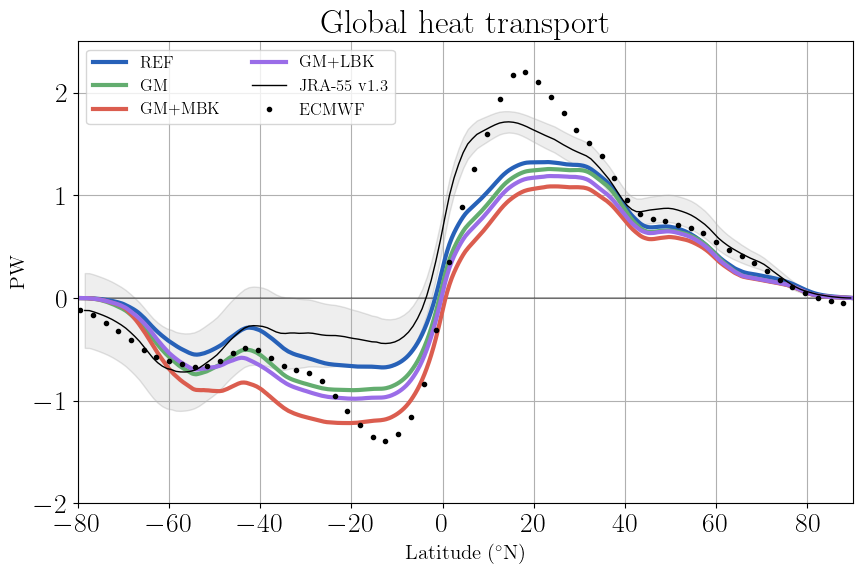

In [8]:
%%time
import netCDF4
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

save_path = 'png/'


xlim=(-80,90)
ylim=(-2.5,3.0)


fig = plt.figure(figsize=(10,6))
plt.plot(lat, lat*0., 'k', linewidth=0.5)

for i in range(num_sims):
    plt.plot(lat, heats[i], c=c[i], linewidth=3,label=snames[i])

plt.xlim(xlim); plt.ylim(ylim)
title = "Global heat transport"
plt.title(title)
plt.grid(True)


jra = xr.open_dataset('/glade/work/gmarques/cesm/datasets/Heat_transport/jra55fcst_v1_3_annual_1x1/nht_jra55do_v1_3.nc')
jra_mean_global = jra.nht[:,0,:].mean('time').values
jra_std_global = jra.nht[:,0,:].std('time').values
plt.plot(jra.lat, jra_mean_global,'k', label='JRA-55 v1.3', color='#000000', lw=1)
plt.fill_between(jra.lat, jra_mean_global-jra_std_global, jra_mean_global+jra_std_global,
    alpha=0.25, edgecolor='#8D8D8D', facecolor='#BCBCBC')

fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
yobs = fObs.variables['ylat'][:]
ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
plt.plot(yobs,ECMWF['Global'][:],'k.',linewidth=0.5,label='ECMWF')


#pop = xr.open_dataset('/glade/u/home/gmarques/Notebooks/POP/MHT/MHT_mean.g210.GIAF_JRA.v13.gx1v7.01.nc')
#plt.plot(pop.lat_aux_grid.values,pop.MHT_global.values,'tab:orange',linewidth=1,label='POP')


plt.xlabel(r'Latitude (${}^\circ$N)',fontsize=15)
plt.ylabel('PW',fontsize=15)
plt.legend(loc='best',fontsize=12, ncol=2)
plt.ylim(-2.,2.5);

plt.savefig(save_path+title+'.png',dpi=300)